# Applying LinearRegression as meta model

In [55]:
#https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from numpy import split
from numpy import array
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from tensorflow.keras.models import model_from_json
from sklearn.linear_model import LinearRegression
#-----------------------
#required functions
#-----------------------

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = metrics.mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = np.sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores


#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSeparator( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__(self):
        print('-->')
     
    #Return self nothing else to do here    
    def fit(self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform(self, X, y = None ):
        return [X[:, :, i] for i in range(43)]
    
# load save AI models from disk    
def load_all_models(model_names, direc):
    all_models = dict()
    for name in model_names:
        # define filename for this ensemble
        filenameh5 = direc + '\model_' + name + '.h5'
        filenamejason = direc+ '\model_' + name + '.json'
        
        # load model from file
        json_file = open( filenamejason )
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        # load weights into new model
        loaded_model.load_weights(filenameh5)
        # add to list of members
        all_models[name] = (loaded_model)
        print(name + " was oaded model from disk")
    return all_models

# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
    stackX = None
    for name, model in members.items():
        model.compile(optimizer='adam', loss='mse', metrics='mape')
        if name == 'mlp1':
            estimators = []
            estimators.append(( 'separator' , FeatureSeparator()))
            estimators.append(( 'mlp' , model))
            model = Pipeline(estimators)
        # make prediction
        yhat = model.predict(inputX, verbose=0)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = np.dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    model = LinearRegression()
    model.fit(stackedX, inputy)
    return model
#-------------------------
# Load Data
#-------------------------

df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
df=np.log(df+1)

n_input = 14
n_out = 1

scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-28':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 


# convert history into inputs and outputs
# flatten data
sequences_train = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y= split_sequences(sequences_train, n_input, n_out)

sequences_test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
test_x, test_y= split_sequences(sequences_test, n_input, n_out)

n_features = train_x.shape[2]

#-------------------------
# Load Optimum Models
#-------------------------

direc = '''C:\\Users\\98912\\OPT-Models'''
model_names=['mlp1', 'cnn1', 'bdlstm1', 'edlstm1', 'slstm1', 'vlstm1' ]

members = load_all_models(model_names, direc)
stack = stacked_dataset(members, train_x)

# fit stacked model using the ensemble
model = fit_stacked_model(members, train_x, train_y)


mlp1 was oaded model from disk
cnn1 was oaded model from disk
bdlstm1 was oaded model from disk
edlstm1 was oaded model from disk
slstm1 was oaded model from disk
vlstm1 was oaded model from disk
-->
-->


In [70]:
stack_test = stacked_dataset(members, test_x)

-->


In [71]:
predict = model.predict(stack_test)

In [72]:
rmse_predict = metrics.mean_squared_error(predict, test_y)**0.5

rmse_predict

0.022737077098290794

In [74]:
for i in range(6):
    rmse = metrics.mean_squared_error(stack_test[:,i], test_y)**0.5
    print(rmse)


0.021130383857700115
0.040126000132485226
0.022482428314330987
0.021050821548722242
0.0235668667059008
0.019453388739007937


# Applying MH MLP as meta model

In [1]:
#https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from numpy import split
from numpy import array
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from tensorflow.keras.models import model_from_json
from sklearn.linear_model import LinearRegression
#-----------------------
#required functions
#-----------------------

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = metrics.mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = np.sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores


#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSeparator( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__(self):
        print('-->')
     
    #Return self nothing else to do here    
    def fit(self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform(self, X, y = None ):
        return [X[:, :, i] for i in range(43)]
    
# load save AI models from disk    
def load_all_models(model_names, direc):
    all_models = dict()
    for name in model_names:
        # define filename for this ensemble
        filenameh5 = direc + '\model_' + name + '.h5'
        filenamejason = direc+ '\model_' + name + '.json'
        
        # load model from file
        json_file = open( filenamejason )
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        # load weights into new model
        loaded_model.load_weights(filenameh5)
        # add to list of members
        all_models[name] = (loaded_model)
        print(name + " was loaded model from disk")
    return all_models

# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
    stackX = None
    for name, model in members.items():
        model.compile(optimizer='adam', loss='mse', metrics='mape')
        # make prediction
        yhat = model.predict(inputX, verbose=0)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = np.dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX


# define stacked model from multiple member input models
def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for name, model in members.items():
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer._name = 'ensemble_' + name + '_' + layer.name
    # define multi-headed input
    ensemble_visible = [model.input for model in members.values()]
    # concatenate merge output from each model
    output1 = tf.reshape(model.output, [-1,1] )
    ensemble_outputs = [output1 for model in members.values()]
    merge = concatenate(ensemble_outputs)
    hidden = Dense(30, activation='relu')(merge)
    output = Dense(1)(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    # plot graph of ensemble
    #plot_model(model, show_shapes=True, to_file='model_graph.png')
    # compile
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model

# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
    # prepare input data
    x1 = [inputX[:, :, i] for i in range(43)]
    X = x1 + [inputX for _ in range(len(model.input)-1)]
    # encode output data
    model.fit(X, inputy, epochs=300, verbose=0)
    
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
    # prepare input data
    x1 = [inputX[:, :, i] for i in range(43)]
    X = x1 + [inputX for _ in range(len(model.input)-1)]
    # make prediction
    return model.predict(X, verbose=0)
#-------------------------
# Load Data
#-------------------------

df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
df=np.log(df+1)

n_input = 14
n_out = 1

scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-28':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 


# convert history into inputs and outputs
# flatten data
sequences_train = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y= split_sequences(sequences_train, n_input, n_out)

sequences_test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
test_x, test_y= split_sequences(sequences_test, n_input, n_out)

n_features = train_x.shape[2]

#-------------------------
# Load Optimum Models
#-------------------------

direc = '''C:\\Users\\98912\\OPT-Models'''
model_names=['mlp1', 'cnn1', 'bdlstm1', 'edlstm1', 'slstm1', 'vlstm1' ]

members = load_all_models(model_names, direc)

# define ensemble model
stacked_model = define_stacked_model(members)

# fit stacked model on test dataset
fit_stacked_model(stacked_model, train_x, train_y)


# make predictions and evaluate
#yhat = predict_stacked_model(stacked_model, testX)


mlp1 was loaded model from disk
cnn1 was loaded model from disk
bdlstm1 was loaded model from disk
edlstm1 was loaded model from disk
slstm1 was loaded model from disk
vlstm1 was loaded model from disk


In [2]:
yhat = predict_stacked_model(stacked_model, test_x)
yhat

array([[0.66370595],
       [0.6384217 ],
       [0.6335252 ],
       [0.6450613 ],
       [0.66526735],
       [0.65516317],
       [0.6617247 ],
       [0.6611823 ],
       [0.6653236 ],
       [0.6830327 ],
       [0.688352  ],
       [0.65019697],
       [0.66520226],
       [0.66799974],
       [0.6874409 ],
       [0.6767623 ],
       [0.68483615],
       [0.6651831 ],
       [0.67404354],
       [0.6828698 ],
       [0.6874637 ],
       [0.68082064],
       [0.6834365 ],
       [0.7041582 ],
       [0.7245355 ],
       [0.7190739 ],
       [0.73013574],
       [0.726242  ],
       [0.72329986],
       [0.7389492 ],
       [0.7445468 ],
       [0.7402724 ],
       [0.75260484],
       [0.7608646 ],
       [0.7612126 ],
       [0.76418877],
       [0.7600927 ],
       [0.7621249 ],
       [0.76422256],
       [0.77411467],
       [0.7739304 ],
       [0.77317214],
       [0.7774142 ],
       [0.7614769 ],
       [0.7343496 ],
       [0.7348715 ],
       [0.7206171 ],
       [0.711

In [148]:
rmse_predict = metrics.mean_squared_error(yhat, test_y)**0.5

rmse_predict

0.029162536686900765

# Ensemble modelling using different trainings

In [223]:
#https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from numpy import split
from numpy import array
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import load_model
from os import makedirs

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSeparator( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__(self):
        print('-->')
     
    #Return self nothing else to do here    
    def fit(self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform(self, X, y = None ):
        return [X[:, :, i] for i in range(43)]
def MHMLP_model():
    n_input = 14
    n_features = 43
    n_out = 1
    visible = [Input(shape=(n_input,)) for i in range(n_features)]
    dense = [Dense(50, activation='relu', kernel_regularizer=l1(0.01))(visible[i]) for i in range(n_features)]
    merge = concatenate([dense[i] for i in range(n_features)])
    output = Dense(n_out)(merge)
    model = Model(inputs=[visible[i] for i in range(n_features)], outputs=output)
    model.compile(optimizer='Adam', loss='mse', metrics='mape')
    return model
model_MHMLP = MHMLP_model()

'''# turn MHMLP into pipeline with separate input data
estimators = []
estimators.append(( 'separator' , FeatureSeparator()))
estimators.append(( 'mlp' , model_MHMLP))
model_MHMLPpl = Pipeline(estimators)'''

def CNN_model():
    n_input = 14
    n_features = 43
    n_out = 1
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=(n_input,n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu', kernel_regularizer=l1(0.01)))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model
model_CNN = CNN_model()


def VLSTM_model():
    n_input = 14
    n_features = 43
    n_out = 1
    model = Sequential()
    model.add(LSTM(64, activation='sigmoid', input_shape=(n_input, n_features)))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model
model_VLSTM = VLSTM_model()


ModelType='Stacked LSTM'
def SLSTM_model():
    n_input = 14
    n_features = 43
    n_out = 1
    model = Sequential()
    model.add(LSTM(50, activation='sigmoid', return_sequences=True, input_shape=(n_input,n_features)))
    model.add(LSTM(25, activation='sigmoid'))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model
model_SLSTM = SLSTM_model()


def BDLSTM_model():
    n_input = 14
    n_features = 43
    n_out = 1
    model = Sequential()
    model.add(Bidirectional(LSTM(16, activation='sigmoid'), input_shape=(n_input, n_features)))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model
model_BDLSTM = BDLSTM_model()


def EDLSTM_model():
    n_input = 14
    n_features = 43
    n_out = 1
    model = Sequential()
    model.add(LSTM(100, activation='sigmoid', input_shape=(n_input, n_features)))
    model.add(RepeatVector(n_out))
    model.add(LSTM(100, activation='sigmoid', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model
model_EDLSTM = EDLSTM_model()

# get a list of models to evaluate
def get_models():
    models = dict()
    models['MHMLP'] = model_MHMLP
    models['CNN'] = model_CNN
    models['VLSTM'] = model_VLSTM
    models['SLSTM'] = model_SLSTM
    models['BDLSTM'] = model_BDLSTM
    models['EDLSTM'] = model_EDLSTM
    return models


# genmerate different fits of models and save the output models
def gen_multifit(model_list, n_repeat, X_train, Y_train):
    for name, model in model_list.items():
        if name == 'MHMLP':
            X = [X_train[:, :, i] for i in range(43)]
            batch_size=30 
            epochs=2000
            for i in range(n_repeat):
                model.fit(X, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)
                filename = 'basemodels/' + name + '_' + str(i + 1) + '.h5'
                model.save(filename)
                print('>Saved %s' % filename)
        if name == 'CNN':
            batch_size=30 
            epochs=3000
            for i in range(n_repeat):
                model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)
                filename = 'basemodels/' + name + '_' + str(i + 1) + '.h5'
                model.save(filename)
                print('>Saved %s' % filename)
        if name == 'VLSTM':
            batch_size=30 
            epochs=400
            for i in range(n_repeat):
                model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)
                filename = 'basemodels/' + name + '_' + str(i + 1) + '.h5'
                model.save(filename)
                print('>Saved %s' % filename)
        if name == 'SLSTM':
            batch_size=30 
            epochs=200
            for i in range(n_repeat):
                model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)
                filename = 'basemodels/' + name + '_' + str(i + 1) + '.h5'
                model.save(filename)
                print('>Saved %s' % filename)
        if name == 'BDLSTM':
            batch_size=30 
            epochs=400
            for i in range(n_repeat):
                model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)
                filename = 'basemodels/' + name + '_' + str(i + 1) + '.h5'
                model.save(filename)
                print('>Saved %s' % filename)
        if name == 'EDLSTM':
            batch_size=30 
            epochs=200
            for i in range(n_repeat):
                model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)
                filename = 'basemodels/' + name + '_' + str(i + 1) + '.h5'
                model.save(filename)
                print('>Saved %s' % filename)
            
# load models from file
def load_all_models(model_list, n_repeat):
    all_models = dict()
    for name in model_list:
        for i in range(n_repeat):
            # define filename for this ensemble
            filename =  name + '_' + str(i + 1) + '.h5'
            filedir = 'basemodels/' + name + '_' + str(i + 1) + '.h5'
            # load model from file
            all_models[filename] = load_model(filedir)
            print('>loaded %s' % filename)
    return all_models


# evaluate models 
def evaluate_model(model, X, y):
    y_hat = model.predict(X)
    y_hatrev = np.exp(scaler.inverse_transform(np.concatenate((y_hat.reshape(y_hat.shape[0]*y_hat.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(y_hat),42))), axis=1))[:,0])-1
    yrev = np.exp(scaler.inverse_transform(np.concatenate((y.reshape(y.shape[0]*y.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(y),42))), axis=1))[:,0])-1
    rmse = np.sqrt(np.mean((yrev-y_hatrev)**2))
    mape = np.mean(np.abs((yrev-y_hatrev)*100/yrev)) 
    return rmse , mape, y_hat


# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX, y):
    stackX = None
    stack_mape = None
    stack_rmse = None
    for name, model in members.items():
        model.compile(optimizer='adam', loss='mse', metrics='mape')
        if 'MHMLP' in name:
            X = [inputX[:, :, i] for i in range(43)]
            rmse , mape, y_hat = evaluate_model(model, X, y)
        else:
            rmse , mape, y_hat = evaluate_model(model, inputX, y)
        
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = y_hat
            stack_mape = mape
            stack_rmse = rmse
        else:
            stackX = np.dstack((stackX, y_hat))
            stack_mape = np.dstack((stack_mape, mape))
            stack_rmse = np.dstack((stack_rmse, rmse))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX, stack_mape, stack_rmse


# define stacked model from multiple member input models
'''def define_stacked_mlp(members):
    # update all layers in all models to not be trainable
    for name, model in members.items():
        if 'MHMLP' in name:
            for i in range(43):
                model.input[i]._name = 'ensemble_' + name.split('.')[0]+ '_' + model.input[i].name
        else:
            model.input._name = 'ensemble_' + name.split('.')[0] + '_' + model.input.name
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer._name = 'ensemble_' + name.split('.')[0] + '_' + layer.name
    # define multi-headed input
    ensemble_visible = [model.input for model in members.values()]
    # concatenate merge output from each model
    output1 = tf.reshape(model.output, [-1,1] )
    ensemble_outputs = [output1 for model in members.values()]
    merge = concatenate(ensemble_outputs)
    hidden = Dense(30, activation='relu')(merge)
    output = Dense(1)(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    # plot graph of ensemble
    #plot_model(model, show_shapes=True, to_file='model_graph.png')
    # compile
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model'''

def define_stacked_mlp():
    # update all layers in all models to not be trainable
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=60))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model


# fit a stacked model
def fit_stacked_mlp(stackX, inputy):
    model.fit(stackX, inputy, epochs=2000, verbose=0)
    return model

# make a prediction with a stacked model
def predict_stacked_mlp(stackX):
    return model.predict(stackX, verbose=0)

# fit a model based on the outputs from the ensemble members
def fit_stacked_lr(stackedX, inputy):
    # fit standalone model
    model = LinearRegression()
    model.fit(stackedX, inputy)
    return model

# make a prediction with the stacked model
def predict_stacked_lr(lrmodel, stackedX):
    # make a prediction
    yhat = lrmodel.predict(stackedX)
    return yhat



#-------------------------
# Load Data
#-------------------------
    
'''df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
df=np.log(df+1)

n_input = 14
n_out = 1

scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-14':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 


# convert history into inputs and outputs
# flatten data
sequences_train = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y = split_sequences(sequences_train, n_input, n_out)

sequences_test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
test_x, test_y = split_sequences(sequences_test, n_input, n_out)

train_x0, train_x1, train_y0, train_y1 = train_test_split(train_x, train_y, test_size=0.3, random_state=2)

n_features = train_x.shape[2]'''
#--------------------------
# Define models using kersa and kerasregressor
#--------------------------

'''n_repeat = 10

# get the models to evaluate
Base_models = get_models()

makedirs('basemodels')

# Build models and save different fitted models
gen_multifit(Base_models, n_repeat, train_x0, train_y0)

# Load different fitted saved models
Base_models_trained = load_all_models(list(Base_models.keys()), n_repeat)

# evaluate the basemodels and creat stack data base
stackX0, mape0, rmse0 = stacked_dataset(Base_models_trained, train_x1, train_y1)'''

# build the stacked models using database0
stacked_mlp = define_stacked_mlp()
stacked_mlp = fit_stacked_mlp(stackX0, train_y1)
stacked_lr = fit_stacked_lr(stackX0, train_y1)

# make prediction based on training dataset
#stackX1, mape1, rmse1 = stacked_dataset(Base_models_trained, test_x, test_y)
predict_smlp = predict_stacked_mlp(stackX1)
predict_slr = predict_stacked_lr(stacked_lr, stackX1 )

# evaluate ensemble models

y_hatrev_smlp = np.exp(scaler.inverse_transform(np.concatenate((predict_smlp.reshape(predict_smlp.shape[0]*predict_smlp.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(predict_smlp),42))), axis=1))[:,0])-1

y_hatrev_slr = np.exp(scaler.inverse_transform(np.concatenate((predict_slr.reshape(predict_slr.shape[0]*predict_slr.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(predict_slr),42))), axis=1))[:,0])-1

yrev = np.exp(scaler.inverse_transform(np.concatenate((test_y.reshape(test_y.shape[0]*test_y.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(test_y),42))), axis=1))[:,0])-1
rmse_smlp = np.sqrt(np.mean((yrev-y_hatrev_smlp)**2))
mape_smlp = np.mean(np.abs((yrev-y_hatrev_smlp)*100/yrev)) 

rmse_slr = np.sqrt(np.mean((yrev-y_hatrev_slr)**2))
mape_slr = np.mean(np.abs((yrev-y_hatrev_slr)*100/yrev))

In [226]:
stackX0.shape

(324, 60)

In [227]:
stackX1.shape

(154, 60)

In [236]:
rmse1

array([[[1415.84583809, 1323.79098419, 1418.90787659, 1484.4744332 ,
         1384.62751786, 1534.29526489, 1492.52546081, 1406.76408733,
         1387.08326487, 1332.81832755,  354.74380352,  261.63892369,
          275.5480107 ,  464.81360042,  354.91891322,  262.35871483,
          266.5888619 ,  265.02778152,  277.75431369,  263.56031255,
          177.78666275,  263.10923917,  440.48115921,  682.56148218,
          888.8115423 ,  919.76069128,  955.0212914 ,  978.82283008,
          935.76985436,  898.63533834,  283.2608583 ,  492.23986673,
          688.00065301,  777.50319306,  885.31977617,  937.27097098,
          922.1772517 ,  941.36538139,  995.32453897,  977.91428965,
          191.39292817,  371.94960939,  533.63155257,  608.21939686,
          698.59249739,  773.03829863,  904.56799605,  968.50167042,
          981.61538133, 1022.02360969,  210.93369809,  269.7893469 ,
          467.30622466,  622.50240248,  639.55144112,  698.52300689,
          838.4925581 ,  868.39354

In [237]:
'''np.save('stackX0.npy', stackX0, allow_pickle=True)
np.save('stackX1.npy', stackX1, allow_pickle=True)
np.save('rmse0.npy', rmse0, allow_pickle=True)
np.save('rmse1.npy', rmse1, allow_pickle=True)
np.save('mape0.npy', mape0, allow_pickle=True)
np.save('mape1.npy', mape1, allow_pickle=True)'''

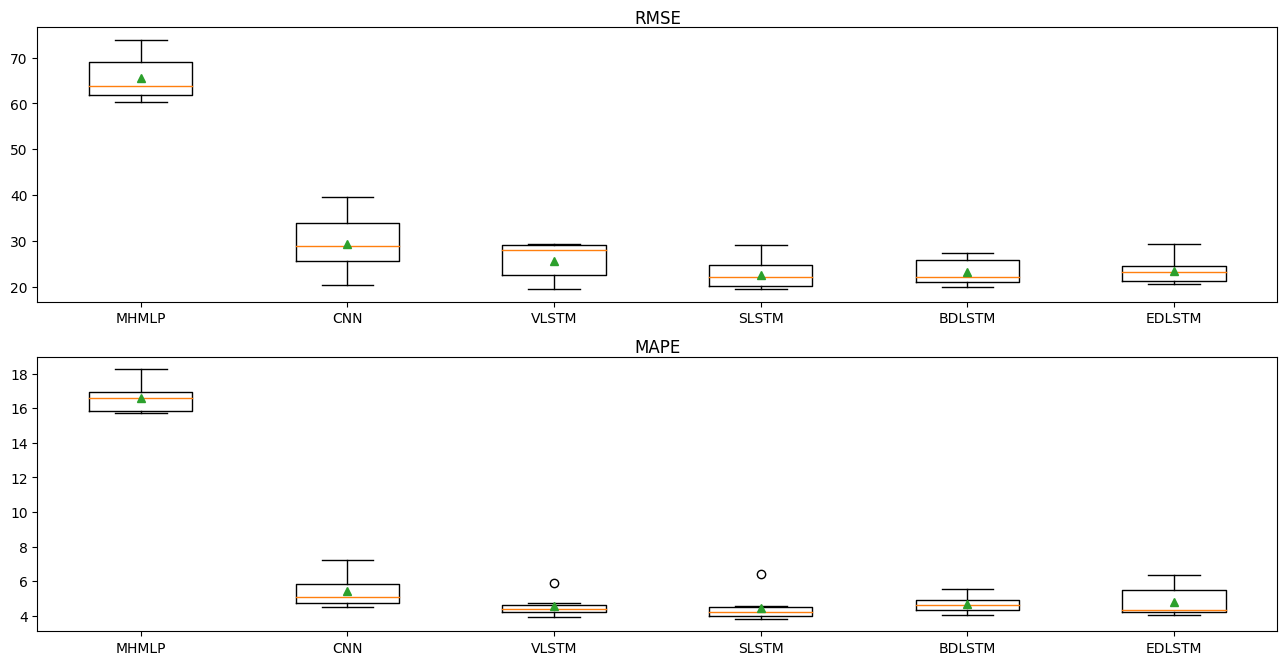

In [247]:
name=['MHMLP','CNN','VLSTM','SLSTM','BDLSTM','EDLSTM'] 
rmse=[]
mape=[]
for i in range(6):
    rmse.append(rmse0[0,0,i*10:(i+1)*10-1])  
    mape.append(mape0[0,0,i*10:(i+1)*10-1])
    
plt.figure(figsize=(16,8), dpi=100)
plt.subplot(211)
plt.title('RMSE', pad=-40)
plt.boxplot(rmse, labels=name, showmeans=True)

plt.subplot(212)
plt.title('MAPE', pad=-40)
plt.boxplot(mape, labels=name, showmeans=True)
plt.show()


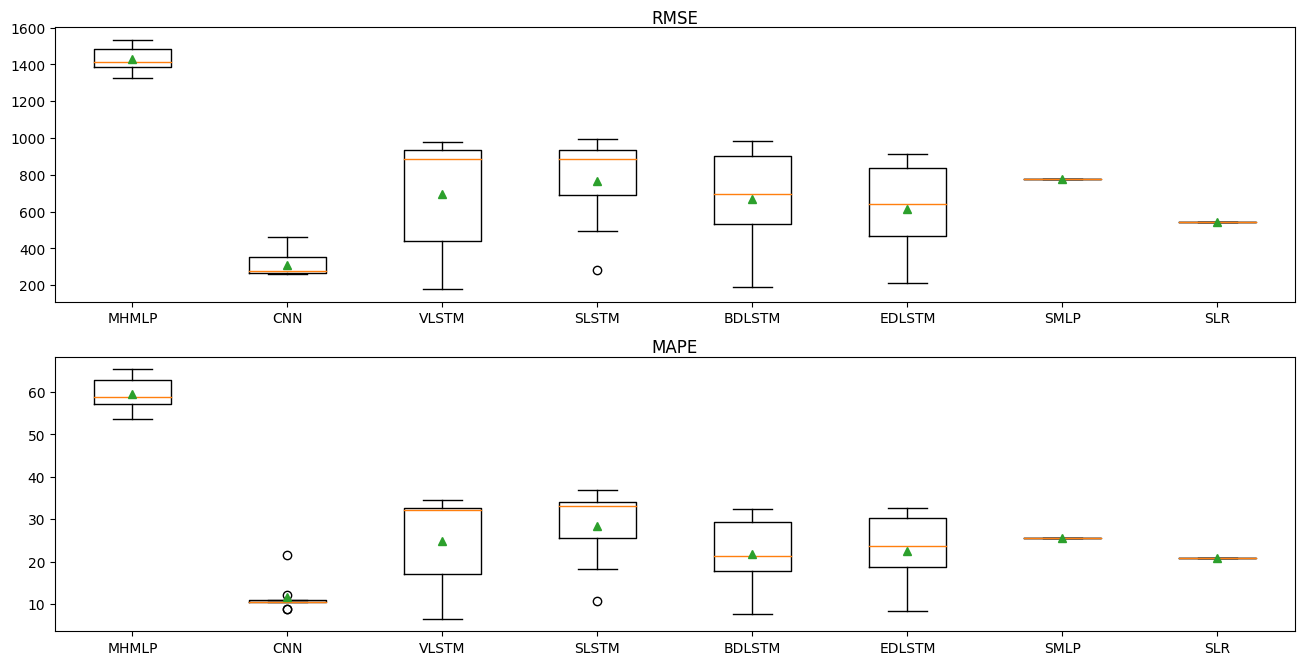

In [260]:
name=['MHMLP','CNN','VLSTM','SLSTM','BDLSTM','EDLSTM','SMLP', 'SLR'] 
rmse=[]
mape=[]
for i in range(6):
    rmse.append(rmse1[0,0,i*10:(i+1)*10-1])  
    mape.append(mape1[0,0,i*10:(i+1)*10-1])
rmse.append([rmse_smlp])
rmse.append([rmse_slr])
mape.append([mape_smlp])
mape.append([mape_slr])

plt.figure(figsize=(16,8), dpi=100)
plt.subplot(211)
plt.title('RMSE', pad=-40)
plt.boxplot(rmse, labels=name, showmeans=True)


plt.subplot(212)
plt.title('MAPE', pad=-40)
plt.boxplot(mape, labels=name, showmeans=True)
plt.show()

In [249]:
Base_models

{'MHMLP': <tensorflow.python.keras.engine.functional.Functional at 0x2e4cf1ba7c0>,
 'CNN': <tensorflow.python.keras.engine.sequential.Sequential at 0x2e4cb0efc10>,
 'VLSTM': <tensorflow.python.keras.engine.sequential.Sequential at 0x2e4a1187370>,
 'SLSTM': <tensorflow.python.keras.engine.sequential.Sequential at 0x2e4b4eb1ac0>,
 'BDLSTM': <tensorflow.python.keras.engine.sequential.Sequential at 0x2e4cc516040>,
 'EDLSTM': <tensorflow.python.keras.engine.sequential.Sequential at 0x2e4e12f1eb0>}

In [261]:
#here we use all training set for both initial model and ensemble model training
#-------------------------
# Load Data
#-------------------------
    
df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
df=np.log(df+1)

n_input = 14
n_out = 1

scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-14':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 


# convert history into inputs and outputs
# flatten data
sequences_train = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y = split_sequences(sequences_train, n_input, n_out)

sequences_test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
test_x, test_y = split_sequences(sequences_test, n_input, n_out)


n_features = train_x.shape[2]
#--------------------------
# Define models using kersa and kerasregressor
#--------------------------

n_repeat = 10

# get the models to evaluate
Base_models = get_models()

makedirs('basemodels')

# Build models and save different fitted models
gen_multifit(Base_models, n_repeat, train_x, train_y)

# Load different fitted saved models
Base_models_trained = load_all_models(list(Base_models.keys()), n_repeat)

# evaluate the basemodels and creat stack data base
stackX0, mape0, rmse0 = stacked_dataset(Base_models_trained, train_x, train_y)

# build the stacked models using database0
stacked_mlp = define_stacked_mlp()
stacked_mlp = fit_stacked_mlp(stackX0, train_y)
stacked_lr = fit_stacked_lr(stackX0, train_y)

# make prediction based on training dataset
stackX1, mape1, rmse1 = stacked_dataset(Base_models_trained, test_x, test_y)
predict_smlp = predict_stacked_mlp(stackX1)
predict_slr = predict_stacked_lr(stacked_lr, stackX1 )

# evaluate ensemble models

y_hatrev_smlp = np.exp(scaler.inverse_transform(np.concatenate((predict_smlp.reshape(predict_smlp.shape[0]*predict_smlp.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(predict_smlp),42))), axis=1))[:,0])-1

y_hatrev_slr = np.exp(scaler.inverse_transform(np.concatenate((predict_slr.reshape(predict_slr.shape[0]*predict_slr.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(predict_slr),42))), axis=1))[:,0])-1

yrev = np.exp(scaler.inverse_transform(np.concatenate((test_y.reshape(test_y.shape[0]*test_y.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(test_y),42))), axis=1))[:,0])-1
rmse_smlp = np.sqrt(np.mean((yrev-y_hatrev_smlp)**2))
mape_smlp = np.mean(np.abs((yrev-y_hatrev_smlp)*100/yrev)) 

rmse_slr = np.sqrt(np.mean((yrev-y_hatrev_slr)**2))
mape_slr = np.mean(np.abs((yrev-y_hatrev_slr)*100/yrev))

>Saved basemodels/MHMLP_1.h5
>Saved basemodels/MHMLP_2.h5
>Saved basemodels/MHMLP_3.h5
>Saved basemodels/MHMLP_4.h5
>Saved basemodels/MHMLP_5.h5
>Saved basemodels/MHMLP_6.h5
>Saved basemodels/MHMLP_7.h5
>Saved basemodels/MHMLP_8.h5
>Saved basemodels/MHMLP_9.h5
>Saved basemodels/MHMLP_10.h5
>Saved basemodels/CNN_1.h5
>Saved basemodels/CNN_2.h5
>Saved basemodels/CNN_3.h5
>Saved basemodels/CNN_4.h5
>Saved basemodels/CNN_5.h5
>Saved basemodels/CNN_6.h5
>Saved basemodels/CNN_7.h5
>Saved basemodels/CNN_8.h5
>Saved basemodels/CNN_9.h5
>Saved basemodels/CNN_10.h5
>Saved basemodels/VLSTM_1.h5
>Saved basemodels/VLSTM_2.h5
>Saved basemodels/VLSTM_3.h5
>Saved basemodels/VLSTM_4.h5
>Saved basemodels/VLSTM_5.h5
>Saved basemodels/VLSTM_6.h5
>Saved basemodels/VLSTM_7.h5
>Saved basemodels/VLSTM_8.h5
>Saved basemodels/VLSTM_9.h5
>Saved basemodels/VLSTM_10.h5
>Saved basemodels/SLSTM_1.h5
>Saved basemodels/SLSTM_2.h5
>Saved basemodels/SLSTM_3.h5
>Saved basemodels/SLSTM_4.h5
>Saved basemodels/SLSTM_5.h5
>S

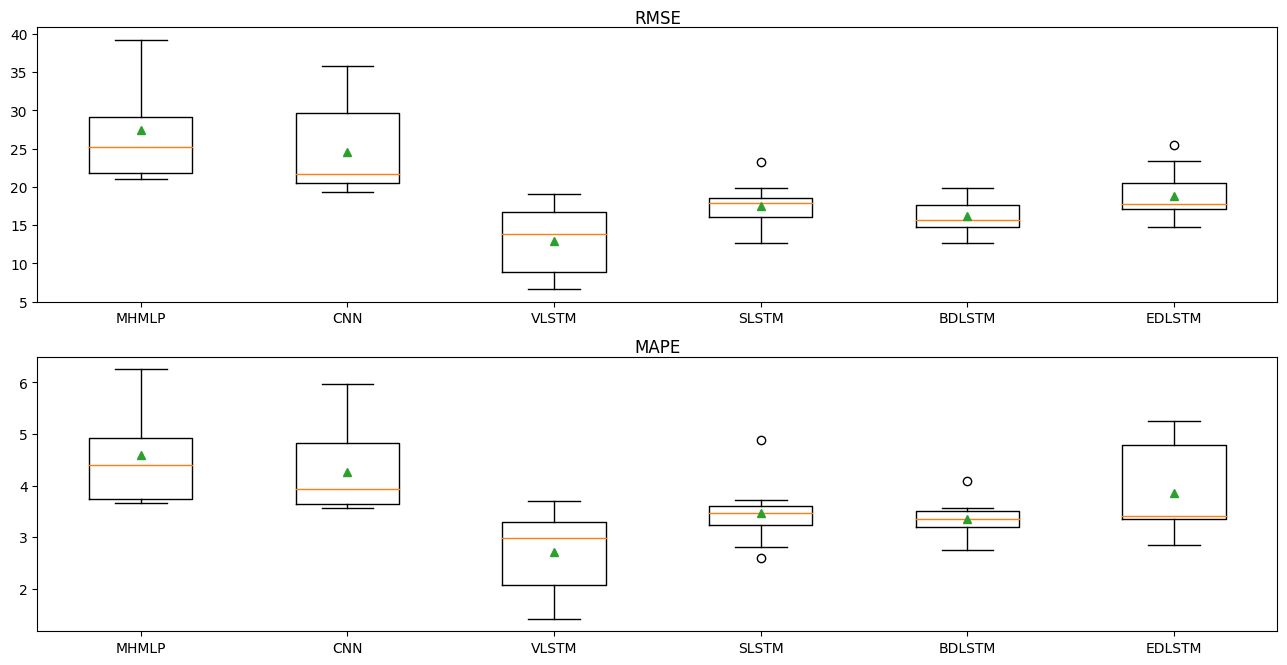

In [262]:
name=['MHMLP','CNN','VLSTM','SLSTM','BDLSTM','EDLSTM'] 
rmse=[]
mape=[]
for i in range(6):
    rmse.append(rmse0[0,0,i*10:(i+1)*10-1])  
    mape.append(mape0[0,0,i*10:(i+1)*10-1])
    
plt.figure(figsize=(16,8), dpi=100)
plt.subplot(211)
plt.title('RMSE', pad=-40)
plt.boxplot(rmse, labels=name, showmeans=True)

plt.subplot(212)
plt.title('MAPE', pad=-40)
plt.boxplot(mape, labels=name, showmeans=True)
plt.show()

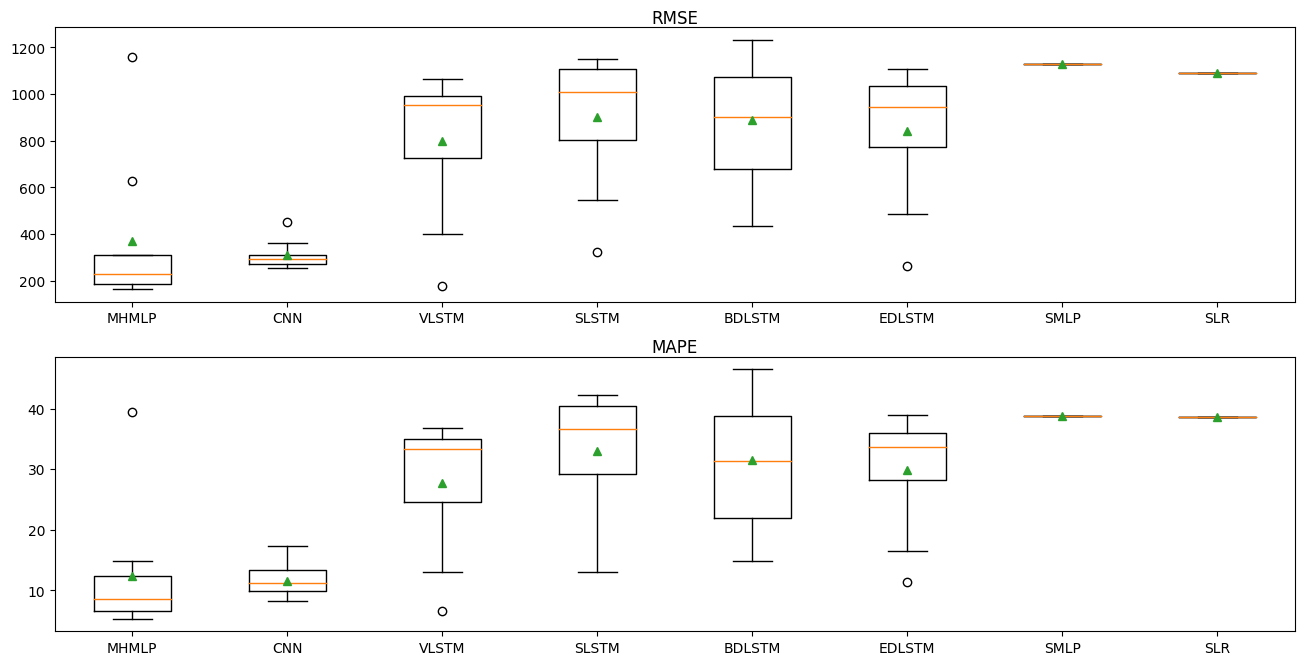

In [263]:
name=['MHMLP','CNN','VLSTM','SLSTM','BDLSTM','EDLSTM','SMLP', 'SLR'] 
rmse=[]
mape=[]
for i in range(6):
    rmse.append(rmse1[0,0,i*10:(i+1)*10-1])  
    mape.append(mape1[0,0,i*10:(i+1)*10-1])
rmse.append([rmse_smlp])
rmse.append([rmse_slr])
mape.append([mape_smlp])
mape.append([mape_slr])

plt.figure(figsize=(16,8), dpi=100)
plt.subplot(211)
plt.title('RMSE', pad=-40)
plt.boxplot(rmse, labels=name, showmeans=True)


plt.subplot(212)
plt.title('MAPE', pad=-40)
plt.boxplot(mape, labels=name, showmeans=True)
plt.show()

In [264]:
np.save('stackX0.npy', stackX0, allow_pickle=True)
np.save('stackX1.npy', stackX1, allow_pickle=True)
np.save('rmse0.npy', rmse0, allow_pickle=True)
np.save('rmse1.npy', rmse1, allow_pickle=True)
np.save('mape0.npy', mape0, allow_pickle=True)
np.save('mape1.npy', mape1, allow_pickle=True)

In [266]:
mape1

array([[[ 5.43471351,  6.59304715,  5.30246481, 12.43869455,
          8.62051056, 10.91558325,  7.24762273, 14.85076272,
         39.38511123, 38.33772771, 11.13322021, 17.27489241,
          8.29003794, 13.28264953, 11.81148744, 10.77018399,
          9.92049985,  8.21844433, 13.28921724, 29.64594973,
          6.61756652, 13.06668138, 24.5912842 , 29.98153687,
         33.35806701, 34.99311015, 34.14490344, 36.08074349,
         36.7844183 , 39.38408513, 12.95477108, 19.19405858,
         29.25581057, 34.40139146, 36.6947808 , 40.29714889,
         40.45793038, 41.69015059, 42.18036471, 44.24030103,
         14.85319775, 19.87305111, 21.91782002, 31.43403525,
         31.17956623, 35.60677653, 38.73316025, 43.83966136,
         46.51456795, 50.42071256, 11.32619779, 16.50336472,
         28.17887942, 31.55795927, 33.60356674, 34.61506547,
         36.06399127, 38.570692  , 39.01013764, 40.24142415]]])

## Ensemble modelling using kfold

In [310]:
#https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from numpy import split
from numpy import array
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import load_model
from os import makedirs
from sklearn.model_selection import KFold

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSeparator( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__(self):
        print('-->')
     
    #Return self nothing else to do here    
    def fit(self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform(self, X, y = None ):
        return [X[:, :, i] for i in range(43)]
def MHMLP_model():
    n_input = 14
    n_features = 43
    n_out = 1
    visible = [Input(shape=(n_input,)) for i in range(n_features)]
    dense = [Dense(50, activation='relu', kernel_regularizer=l1(0.01))(visible[i]) for i in range(n_features)]
    merge = concatenate([dense[i] for i in range(n_features)])
    output = Dense(n_out)(merge)
    model = Model(inputs=[visible[i] for i in range(n_features)], outputs=output)
    model.compile(optimizer='Adam', loss='mse', metrics='mape')
    return model
model_MHMLP = MHMLP_model()

'''# turn MHMLP into pipeline with separate input data
estimators = []
estimators.append(( 'separator' , FeatureSeparator()))
estimators.append(( 'mlp' , model_MHMLP))
model_MHMLPpl = Pipeline(estimators)'''

def CNN_model():
    n_input = 14
    n_features = 43
    n_out = 1
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=(n_input,n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu', kernel_regularizer=l1(0.01)))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model
model_CNN = CNN_model()


def VLSTM_model():
    n_input = 14
    n_features = 43
    n_out = 1
    model = Sequential()
    model.add(LSTM(64, activation='sigmoid', input_shape=(n_input, n_features)))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model
model_VLSTM = VLSTM_model()


ModelType='Stacked LSTM'
def SLSTM_model():
    n_input = 14
    n_features = 43
    n_out = 1
    model = Sequential()
    model.add(LSTM(50, activation='sigmoid', return_sequences=True, input_shape=(n_input,n_features)))
    model.add(LSTM(25, activation='sigmoid'))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model
model_SLSTM = SLSTM_model()


def BDLSTM_model():
    n_input = 14
    n_features = 43
    n_out = 1
    model = Sequential()
    model.add(Bidirectional(LSTM(16, activation='sigmoid'), input_shape=(n_input, n_features)))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model
model_BDLSTM = BDLSTM_model()


def EDLSTM_model():
    n_input = 14
    n_features = 43
    n_out = 1
    model = Sequential()
    model.add(LSTM(100, activation='sigmoid', input_shape=(n_input, n_features)))
    model.add(RepeatVector(n_out))
    model.add(LSTM(100, activation='sigmoid', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model
model_EDLSTM = EDLSTM_model()

# get a list of models to evaluate
def get_models():
    models = dict()
    models['MHMLP'] = model_MHMLP
    models['CNN'] = model_CNN
    models['VLSTM'] = model_VLSTM
    models['SLSTM'] = model_SLSTM
    models['BDLSTM'] = model_BDLSTM
    models['EDLSTM'] = model_EDLSTM
    return models


# genmerate different fits of models and save the output models
def gen_multifit(model_list, n_repeat, X_train, Y_train, kf_index):
    for name, model in model_list.items():
        if name == 'MHMLP':
            batch_size=30 
            epochs=2000
            for i in range(n_repeat):
                X = X_train[kf_index[i]]
                Y = Y_train[kf_index[i]]
                X = [X[:, :, i] for i in range(43)]
                model.fit(X, Y, batch_size=batch_size, epochs=epochs, verbose=0)
                filename = 'basemodels/' + name + '_' + str(i + 1) + '.h5'
                model.save(filename)
                print('>Saved %s' % filename)
        if name == 'CNN':
            batch_size=30 
            epochs=3000
            for i in range(n_repeat):
                X = X_train[kf_index[i]]
                Y = Y_train[kf_index[i]]
                model.fit(X, Y, batch_size=batch_size, epochs=epochs, verbose=0)
                filename = 'basemodels/' + name + '_' + str(i + 1) + '.h5'
                model.save(filename)
                print('>Saved %s' % filename)
        if name == 'VLSTM':
            batch_size=30 
            epochs=400
            for i in range(n_repeat):
                X = X_train[kf_index[i]]
                Y = Y_train[kf_index[i]]
                model.fit(X, Y, batch_size=batch_size, epochs=epochs, verbose=0)
                filename = 'basemodels/' + name + '_' + str(i + 1) + '.h5'
                model.save(filename)
                print('>Saved %s' % filename)
        if name == 'SLSTM':
            batch_size=30 
            epochs=200
            for i in range(n_repeat):
                X = X_train[kf_index[i]]
                Y = Y_train[kf_index[i]]
                model.fit(X, Y, batch_size=batch_size, epochs=epochs, verbose=0)
                filename = 'basemodels/' + name + '_' + str(i + 1) + '.h5'
                model.save(filename)
                print('>Saved %s' % filename)
        if name == 'BDLSTM':
            batch_size=30 
            epochs=400
            for i in range(n_repeat):
                X = X_train[kf_index[i]]
                Y = Y_train[kf_index[i]]
                model.fit(X, Y, batch_size=batch_size, epochs=epochs, verbose=0)
                filename = 'basemodels/' + name + '_' + str(i + 1) + '.h5'
                model.save(filename)
                print('>Saved %s' % filename)
        if name == 'EDLSTM':
            batch_size=30 
            epochs=200
            for i in range(n_repeat):
                X = X_train[kf_index[i]]
                Y = Y_train[kf_index[i]]
                model.fit(X, Y, batch_size=batch_size, epochs=epochs, verbose=0)
                filename = 'basemodels/' + name + '_' + str(i + 1) + '.h5'
                model.save(filename)
                print('>Saved %s' % filename)
            
# load models from file
def load_all_models(model_list, n_repeat):
    all_models = dict()
    for name in model_list:
        for i in range(n_repeat):
            # define filename for this ensemble
            filename =  name + '_' + str(i + 1) + '.h5'
            filedir = 'basemodels/' + name + '_' + str(i + 1) + '.h5'
            # load model from file
            all_models[filename] = load_model(filedir)
            print('>loaded %s' % filename)
    return all_models


# evaluate models 
def evaluate_model(model, X, y):
    y_hat = model.predict(X)
    y_hatrev = np.exp(scaler.inverse_transform(np.concatenate((y_hat.reshape(y_hat.shape[0]*y_hat.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(y_hat),42))), axis=1))[:,0])-1
    yrev = np.exp(scaler.inverse_transform(np.concatenate((y.reshape(y.shape[0]*y.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(y),42))), axis=1))[:,0])-1
    rmse = np.sqrt(np.mean((yrev-y_hatrev)**2))
    mape = np.mean(np.abs((yrev-y_hatrev)*100/yrev)) 
    return rmse , mape, y_hat


# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX, y):
    stackX = None
    stack_mape = None
    stack_rmse = None
    for name, model in members.items():
        model.compile(optimizer='adam', loss='mse', metrics='mape')
        if 'MHMLP' in name:
            X = [inputX[:, :, i] for i in range(43)]
            rmse , mape, y_hat = evaluate_model(model, X, y)
        else:
            rmse , mape, y_hat = evaluate_model(model, inputX, y)
        
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = y_hat
            stack_mape = mape
            stack_rmse = rmse
        else:
            stackX = np.dstack((stackX, y_hat))
            stack_mape = np.dstack((stack_mape, mape))
            stack_rmse = np.dstack((stack_rmse, rmse))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX, stack_mape, stack_rmse


# define stacked model from multiple member input models
def define_stacked_mlp():
    # update all layers in all models to not be trainable
    model = Sequential()
    model.add(Dense(300, activation='relu', input_dim=60))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model


# fit a stacked model
def fit_stacked_mlp(stackX, inputy):
    model.fit(stackX, inputy, epochs=2000, verbose=0)
    return model

# make a prediction with a stacked model
def predict_stacked_mlp(stackX):
    return model.predict(stackX, verbose=0)

# fit a model based on the outputs from the ensemble members
def fit_stacked_lr(stackedX, inputy):
    # fit standalone model
    model = LinearRegression()
    model.fit(stackedX, inputy)
    return model

# make a prediction with the stacked model
def predict_stacked_lr(lrmodel, stackedX):
    # make a prediction
    yhat = lrmodel.predict(stackedX)
    return yhat

def kf_train_test_split(X,n):
    kf = KFold(n_splits=n, shuffle=False)
    test_stack=[] 
    train_stack=[]
    for train_index, test_index in kf.split(X):
        test_stack.append(test_index)
        train_stack.append(train_index)
    return train_stack, test_stack

#-------------------------
# Load Data
#-------------------------
    
df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
df=np.log(df+1)

n_input = 14
n_out = 1

scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-14':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 


# convert history into inputs and outputs
# flatten data
sequences_train = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y = split_sequences(sequences_train, n_input, n_out)

sequences_test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
test_x, test_y = split_sequences(sequences_test, n_input, n_out)

kf_train0, kf_test0 = kf_train_test_split(train_x,10)

n_features = train_x.shape[2]
#--------------------------
# Define models using kersa and kerasregressor
#--------------------------

n_repeat = 10

# get the models to evaluate
Base_models = get_models()

makedirs('basemodels')

# Build models and save different fitted models
gen_multifit(Base_models, n_repeat, train_x, train_y, kf_train0)

# Load different fitted saved models
Base_models_trained = load_all_models(list(Base_models.keys()), n_repeat)

# evaluate the basemodels and creat stack data base
stackX0, mape0, rmse0 = stacked_dataset(Base_models_trained, train_x, train_y)

# build the stacked models using database0
stacked_mlp = define_stacked_mlp()
stacked_mlp = fit_stacked_mlp(stackX0, train_y)
stacked_lr = fit_stacked_lr(stackX0, train_y)

# make prediction based on training dataset
stackX1, mape1, rmse1 = stacked_dataset(Base_models_trained, test_x, test_y)
predict_smlp = predict_stacked_mlp(stackX1)
predict_slr = predict_stacked_lr(stacked_lr, stackX1 )

# evaluate ensemble models

y_hatrev_smlp = np.exp(scaler.inverse_transform(np.concatenate((predict_smlp.reshape(predict_smlp.shape[0]*predict_smlp.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(predict_smlp),42))), axis=1))[:,0])-1

y_hatrev_slr = np.exp(scaler.inverse_transform(np.concatenate((predict_slr.reshape(predict_slr.shape[0]*predict_slr.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(predict_slr),42))), axis=1))[:,0])-1

yrev = np.exp(scaler.inverse_transform(np.concatenate((test_y.reshape(test_y.shape[0]*test_y.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(test_y),42))), axis=1))[:,0])-1
rmse_smlp = np.sqrt(np.mean((yrev-y_hatrev_smlp)**2))
mape_smlp = np.mean(np.abs((yrev-y_hatrev_smlp)*100/yrev)) 

rmse_slr = np.sqrt(np.mean((yrev-y_hatrev_slr)**2))
mape_slr = np.mean(np.abs((yrev-y_hatrev_slr)*100/yrev))

>Saved basemodels/MHMLP_1.h5
>Saved basemodels/MHMLP_2.h5
>Saved basemodels/MHMLP_3.h5
>Saved basemodels/MHMLP_4.h5
>Saved basemodels/MHMLP_5.h5
>Saved basemodels/MHMLP_6.h5
>Saved basemodels/MHMLP_7.h5
>Saved basemodels/MHMLP_8.h5
>Saved basemodels/MHMLP_9.h5
>Saved basemodels/MHMLP_10.h5
>Saved basemodels/CNN_1.h5
>Saved basemodels/CNN_2.h5
>Saved basemodels/CNN_3.h5
>Saved basemodels/CNN_4.h5
>Saved basemodels/CNN_5.h5
>Saved basemodels/CNN_6.h5
>Saved basemodels/CNN_7.h5
>Saved basemodels/CNN_8.h5
>Saved basemodels/CNN_9.h5
>Saved basemodels/CNN_10.h5
>Saved basemodels/VLSTM_1.h5
>Saved basemodels/VLSTM_2.h5
>Saved basemodels/VLSTM_3.h5
>Saved basemodels/VLSTM_4.h5
>Saved basemodels/VLSTM_5.h5
>Saved basemodels/VLSTM_6.h5
>Saved basemodels/VLSTM_7.h5
>Saved basemodels/VLSTM_8.h5
>Saved basemodels/VLSTM_9.h5
>Saved basemodels/VLSTM_10.h5
>Saved basemodels/SLSTM_1.h5
>Saved basemodels/SLSTM_2.h5
>Saved basemodels/SLSTM_3.h5
>Saved basemodels/SLSTM_4.h5
>Saved basemodels/SLSTM_5.h5
>S

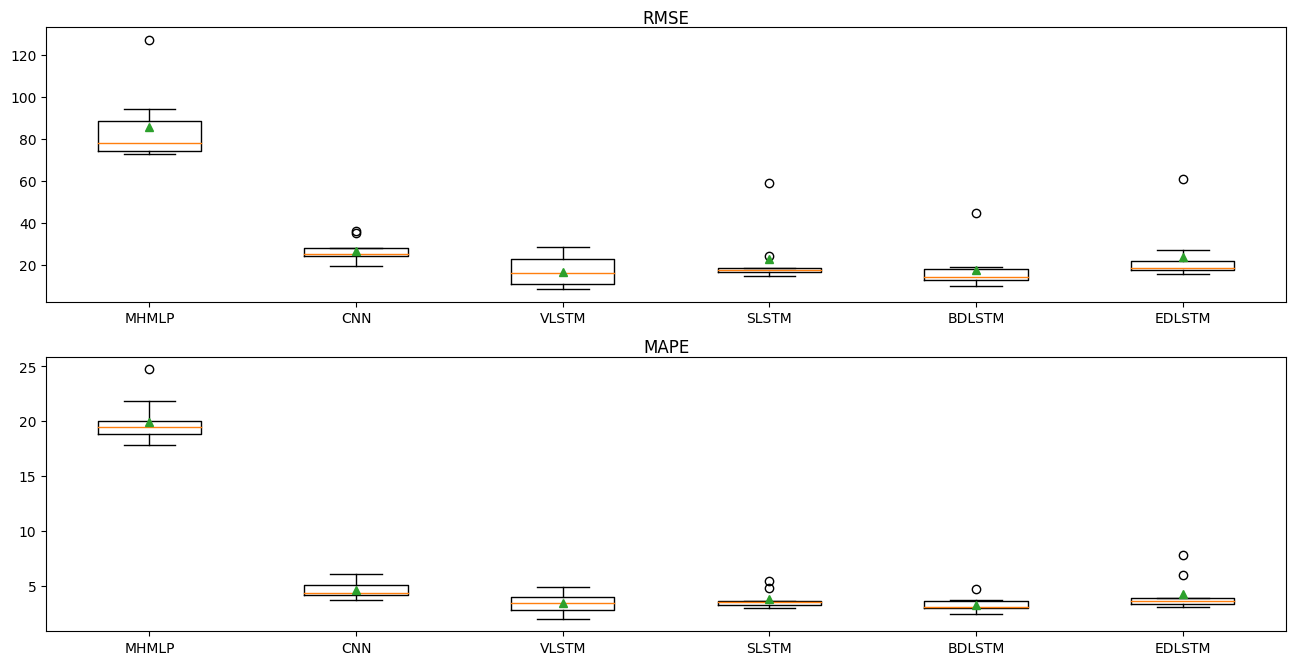

In [311]:
name=['MHMLP','CNN','VLSTM','SLSTM','BDLSTM','EDLSTM'] 
rmse=[]
mape=[]
for i in range(6):
    rmse.append(rmse0[0,0,i*10:(i+1)*10-1])  
    mape.append(mape0[0,0,i*10:(i+1)*10-1])
    
plt.figure(figsize=(16,8), dpi=100)
plt.subplot(211)
plt.title('RMSE', pad=-40)
plt.boxplot(rmse, labels=name, showmeans=True)

plt.subplot(212)
plt.title('MAPE', pad=-40)
plt.boxplot(mape, labels=name, showmeans=True)
plt.show()


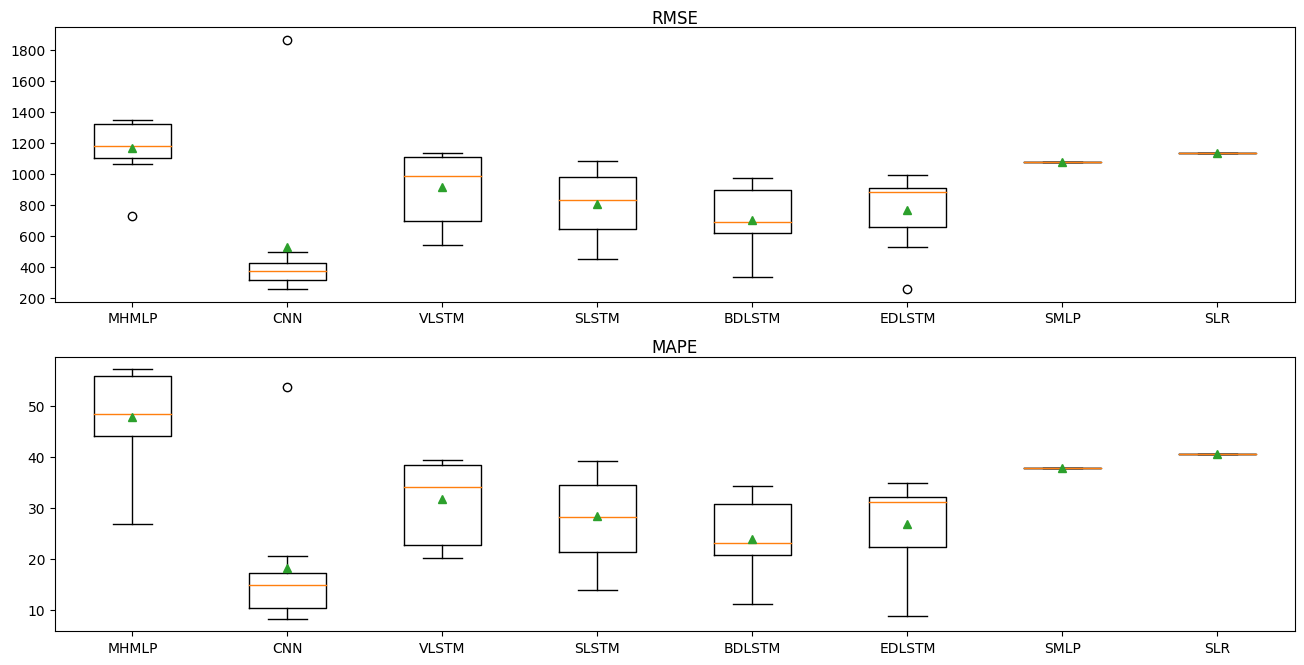

In [312]:
name=['MHMLP','CNN','VLSTM','SLSTM','BDLSTM','EDLSTM','SMLP', 'SLR'] 
rmse=[]
mape=[]
for i in range(6):
    rmse.append(rmse1[0,0,i*10:(i+1)*10-1])  
    mape.append(mape1[0,0,i*10:(i+1)*10-1])
rmse.append([rmse_smlp])
rmse.append([rmse_slr])
mape.append([mape_smlp])
mape.append([mape_slr])

plt.figure(figsize=(16,8), dpi=100)
plt.subplot(211)
plt.title('RMSE', pad=-40)
plt.boxplot(rmse, labels=name, showmeans=True)


plt.subplot(212)
plt.title('MAPE', pad=-40)
plt.boxplot(mape, labels=name, showmeans=True)
plt.show()

In [313]:
np.save('stackX0.npy', stackX0, allow_pickle=True)
np.save('stackX1.npy', stackX1, allow_pickle=True)
np.save('rmse0.npy', rmse0, allow_pickle=True)
np.save('rmse1.npy', rmse1, allow_pickle=True)
np.save('mape0.npy', mape0, allow_pickle=True)
np.save('mape1.npy', mape1, allow_pickle=True)

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from numpy import split
from numpy import array
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import load_model
from os import makedirs
from sklearn.model_selection import KFold

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


def MHMLP_model():
    n_input = 14
    n_features = 43
    n_out = 1
    visible = [Input(shape=(n_input,)) for i in range(n_features)]
    dense = [Dense(50, activation='relu')(visible[i]) for i in range(n_features)]
    merge = concatenate([dense[i] for i in range(n_features)])
    output = Dense(n_out)(merge)
    model = Model(inputs=[visible[i] for i in range(n_features)], outputs=output)
    model.compile(optimizer='Adam', loss='mse', metrics='mape')
    return model
model_MHMLP = MHMLP_model()

'''# turn MHMLP into pipeline with separate input data
estimators = []
estimators.append(( 'separator' , FeatureSeparator()))
estimators.append(( 'mlp' , model_MHMLP))
model_MHMLPpl = Pipeline(estimators)'''

def CNN_model():
    n_input = 14
    n_features = 43
    n_out = 1
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=(n_input,n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu', kernel_regularizer=l1(0.01)))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model
model_CNN = CNN_model()


def VLSTM_model():
    n_input = 14
    n_features = 43
    n_out = 1
    model = Sequential()
    model.add(LSTM(64, activation='sigmoid', input_shape=(n_input, n_features)))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model
model_VLSTM = VLSTM_model()


ModelType='Stacked LSTM'
def SLSTM_model():
    n_input = 14
    n_features = 43
    n_out = 1
    model = Sequential()
    model.add(LSTM(50, activation='sigmoid', return_sequences=True, input_shape=(n_input,n_features)))
    model.add(LSTM(25, activation='sigmoid'))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model
model_SLSTM = SLSTM_model()


def BDLSTM_model():
    n_input = 14
    n_features = 43
    n_out = 1
    model = Sequential()
    model.add(Bidirectional(LSTM(16, activation='sigmoid'), input_shape=(n_input, n_features)))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model
model_BDLSTM = BDLSTM_model()


def EDLSTM_model():
    n_input = 14
    n_features = 43
    n_out = 1
    model = Sequential()
    model.add(LSTM(100, activation='sigmoid', input_shape=(n_input, n_features)))
    model.add(RepeatVector(n_out))
    model.add(LSTM(100, activation='sigmoid', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model
model_EDLSTM = EDLSTM_model()


# get a list of models to evaluate
def get_models():
    models = dict()
    models['MHMLP'] = model_MHMLP
    models['CNN'] = model_CNN
    models['VLSTM'] = model_VLSTM
    models['SLSTM'] = model_SLSTM
    models['BDLSTM'] = model_BDLSTM
    models['EDLSTM'] = model_EDLSTM
    return models


# evaluate models using kfold validation
def get_kfvalid(model_list, n_slit, X_train, Y_train):
    seed = 7
    np.random.seed(seed)
    kf = KFold(n_splits=n_slit, shuffle=True, random_state=seed)    
    Scores = dict()
    Yhat = dict()
    Y = dict()
    for name, model in model_list.items():
        i=0
        cvscores = []
        cvyhat = []
        cvy = []
        if name == 'MHMLP':
            batch_size=30 
            epochs=2000
            for train, test in kf.split(X_train, Y_train):
                Xtr = [X_train[train][:, :, i] for i in range(43)]
                # Fit the model
                model.fit(Xtr , Y_train[train], batch_size=batch_size, epochs=epochs, verbose=0)
                # save model
                filename = 'basemodels/' + name + '_' + str(i + 1) + '.h5'
                model.save(filename)
                print('>Saved %s' % filename)
                i=i+1
                # evaluate the model
                Xte = [X_train[test][:, :, i] for i in range(43)]
                scores = model.evaluate(Xte, train_y[test], verbose=0)
                cvscores.append(scores)
                # produce yhat
                y_hat = model.predict(Xte)
                cvyhat.append(y_hat)
                cvy.append(train_y[test])
        Scores[name] = cvscores
        Yhat[name] = cvyhat
        Y[name] = cvy
        
        if name == 'CNN':
            batch_size=30 
            epochs=3000
            for train, test in kf.split(X_train, Y_train):
                # Fit the model
                model.fit(X_train[train] , Y_train[train], batch_size=batch_size, epochs=epochs, verbose=0)
                # save model
                filename = 'basemodels/' + name + '_' + str(i + 1) + '.h5'
                model.save(filename)
                print('>Saved %s' % filename)
                i=i+1
                # evaluate the model
                scores = model.evaluate(X_train[test], train_y[test], verbose=0)
                cvscores.append(scores)
                # produce yhat
                y_hat = model.predict(X_train[test])
                cvyhat.append(y_hat)
                cvy.append(train_y[test])
        Scores[name] = cvscores
        Yhat[name] = cvyhat
        Y[name] = cvy
        
        if name == 'VLSTM':
            batch_size=30 
            epochs=400
            for train, test in kf.split(X_train, Y_train):
                # Fit the model
                model.fit(X_train[train] , Y_train[train], batch_size=batch_size, epochs=epochs, verbose=0)
                # save model
                filename = 'basemodels/' + name + '_' + str(i + 1) + '.h5'
                model.save(filename)
                print('>Saved %s' % filename)
                i=i+1
                # evaluate the model
                scores = model.evaluate(X_train[test], train_y[test], verbose=0)
                cvscores.append(scores)  
                # produce yhat
                y_hat = model.predict(X_train[test])
                cvyhat.append(y_hat)
                cvy.append(train_y[test])
        Scores[name] = cvscores
        Yhat[name] = cvyhat
        Y[name] = cvy
        
        if name == 'SLSTM':
            batch_size=30 
            epochs=200
            for train, test in kf.split(X_train, Y_train):
                # Fit the model
                model.fit(X_train[train] , Y_train[train], batch_size=batch_size, epochs=epochs, verbose=0)
                # save model
                filename = 'basemodels/' + name + '_' + str(i + 1) + '.h5'
                model.save(filename)
                print('>Saved %s' % filename)
                i=i+1
                # evaluate the model
                scores = model.evaluate(X_train[test], train_y[test], verbose=0)
                cvscores.append(scores) 
                # produce yhat
                y_hat = model.predict(X_train[test])
                cvyhat.append(y_hat)
                cvy.append(train_y[test])
        Scores[name] = cvscores
        Yhat[name] = cvyhat
        Y[name] = cvy
        
        if name == 'BDLSTM':
            batch_size=30 
            epochs=400
            for train, test in kf.split(X_train, Y_train):
                # Fit the model
                model.fit(X_train[train] , Y_train[train], batch_size=batch_size, epochs=epochs, verbose=0)
                # save model
                filename = 'basemodels/' + name + '_' + str(i + 1) + '.h5'
                model.save(filename)
                print('>Saved %s' % filename)
                i=i+1
                # evaluate the model
                scores = model.evaluate(X_train[test], train_y[test], verbose=0)
                cvscores.append(scores) 
                # produce yhat
                y_hat = model.predict(X_train[test])
                cvyhat.append(y_hat)
                cvy.append(train_y[test])
        Scores[name] = cvscores
        Yhat[name] = cvyhat
        Y[name] = cvy
        
        if name == 'EDLSTM':
            batch_size=30 
            epochs=200
            for train, test in kf.split(X_train, Y_train):
                # Fit the model
                model.fit(X_train[train] , Y_train[train], batch_size=batch_size, epochs=epochs, verbose=0)
                # save model
                filename = 'basemodels/' + name + '_' + str(i + 1) + '.h5'
                model.save(filename)
                print('>Saved %s' % filename)
                i=i+1
                # evaluate the model
                scores = model.evaluate(X_train[test], train_y[test], verbose=0)
                cvscores.append(scores)
                # produce yhat
                y_hat = model.predict(X_train[test])
                cvyhat.append(y_hat)
                cvy.append(train_y[test])
        Scores[name] = cvscores
        Yhat[name] = cvyhat
        Y[name] = cvy    
    return Scores, Yhat, Y

# load models from file
def load_all_models(model_list, n_repeat):
    all_models = dict()
    for name in model_list:
        for i in range(n_repeat):
            # define filename for this ensemble
            filename =  name + '_' + str(i + 1) + '.h5'
            filedir = 'basemodels/' + name + '_' + str(i + 1) + '.h5'
            # load model from file
            all_models[filename] = load_model(filedir)
            print('>loaded %s' % filename)
    return all_models


# evaluate models 
def evaluate_model(model, X, y):
    y_hat = model.predict(X)
    y_hatrev = np.exp(scaler.inverse_transform(np.concatenate((y_hat.reshape(y_hat.shape[0]*y_hat.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(y_hat),42))), axis=1))[:,0])-1
    yrev = np.exp(scaler.inverse_transform(np.concatenate((y.reshape(y.shape[0]*y.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(y),42))), axis=1))[:,0])-1
    rmse = np.sqrt(np.mean((yrev-y_hatrev)**2))
    mape = np.mean(np.abs((yrev-y_hatrev)*100/yrev)) 
    return rmse , mape, y_hat


# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX, y):
    stackX = None
    stack_mape = None
    stack_rmse = None
    for name, model in members.items():
        model.compile(optimizer='adam', loss='mse', metrics='mape')
        if 'MHMLP' in name:
            X = [inputX[:, :, i] for i in range(43)]
            rmse , mape, y_hat = evaluate_model(model, X, y)
        else:
            rmse , mape, y_hat = evaluate_model(model, inputX, y)
        
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = y_hat
            stack_mape = mape
            stack_rmse = rmse
        else:
            stackX = np.dstack((stackX, y_hat))
            stack_mape = np.dstack((stack_mape, mape))
            stack_rmse = np.dstack((stack_rmse, rmse))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX, stack_mape, stack_rmse


# define stacked model from multiple member input models
def define_stacked_mlp():
    # update all layers in all models to not be trainable
    model = Sequential()
    model.add(Dense(200, activation='relu', input_dim=60))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model


# fit a stacked model
def fit_stacked_mlp(model, stackX, inputy):
    model.fit(stackX, inputy, epochs=2000, verbose=0)
    return model

# make a prediction with a stacked model
def predict_stacked_mlp(model, stackX):
    return model.predict(stackX, verbose=0)

# fit a model based on the outputs from the ensemble members
def fit_stacked_lr(stackedX, inputy):
    # fit standalone model
    model = LinearRegression()
    model.fit(stackedX, inputy)
    return model

# make a prediction with the stacked model
def predict_stacked_lr(lrmodel, stackedX):
    # make a prediction
    yhat = lrmodel.predict(stackedX)
    return yhat

#***********************************************
#-------------------------
# Load Data
#-------------------------
    
df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
df=np.log(df+1)

n_input = 14
n_out = 1

scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-14':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 


# convert history into inputs and outputs
# flatten data
sequences_train = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y = split_sequences(sequences_train, n_input, n_out)

sequences_test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
test_x, test_y = split_sequences(sequences_test, n_input, n_out)

n_features = train_x.shape[2]
#--------------------------
# Define models using kersa and kerasregressor
#--------------------------

n_repeat = 10
#makedirs('basemodels')
Base_models = get_models()
#Scores, Yhat, Y = get_kfvalid(Base_models, 10, train_x, train_y)

# Load different fitted saved models
Base_models_trained = load_all_models(list(Base_models.keys()), n_repeat)

# evaluate the basemodels and creat stack data base
stackX0, mape0, rmse0 = stacked_dataset(Base_models_trained, train_x, train_y)

# build the stacked models using database0
stacked_mlp = define_stacked_mlp()
stacked_mlp = fit_stacked_mlp(stacked_mlp, stackX0, train_y)
stacked_lr = fit_stacked_lr(stackX0, train_y)

# make prediction based on training dataset
stackX1, mape1, rmse1 = stacked_dataset(Base_models_trained, test_x, test_y)
predict_smlp = predict_stacked_mlp(stacked_mlp, stackX1)
predict_slr = predict_stacked_lr(stacked_lr, stackX1 )

# evaluate ensemble models

y_hatrev_smlp = np.exp(scaler.inverse_transform(np.concatenate((predict_smlp.reshape(predict_smlp.shape[0]*predict_smlp.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(predict_smlp),42))), axis=1))[:,0])-1

y_hatrev_slr = np.exp(scaler.inverse_transform(np.concatenate((predict_slr.reshape(predict_slr.shape[0]*predict_slr.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(predict_slr),42))), axis=1))[:,0])-1

yrev = np.exp(scaler.inverse_transform(np.concatenate((test_y.reshape(test_y.shape[0]*test_y.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(test_y),42))), axis=1))[:,0])-1
rmse_smlp = np.sqrt(np.mean((yrev-y_hatrev_smlp)**2))
mape_smlp = np.mean(np.abs((yrev-y_hatrev_smlp)*100/yrev)) 

rmse_slr = np.sqrt(np.mean((yrev-y_hatrev_slr)**2))
mape_slr = np.mean(np.abs((yrev-y_hatrev_slr)*100/yrev))


>loaded MHMLP_1.h5
>loaded MHMLP_2.h5
>loaded MHMLP_3.h5
>loaded MHMLP_4.h5
>loaded MHMLP_5.h5
>loaded MHMLP_6.h5
>loaded MHMLP_7.h5
>loaded MHMLP_8.h5
>loaded MHMLP_9.h5
>loaded MHMLP_10.h5
>loaded CNN_1.h5
>loaded CNN_2.h5
>loaded CNN_3.h5
>loaded CNN_4.h5
>loaded CNN_5.h5
>loaded CNN_6.h5
>loaded CNN_7.h5
>loaded CNN_8.h5
>loaded CNN_9.h5
>loaded CNN_10.h5
>loaded VLSTM_1.h5
>loaded VLSTM_2.h5
>loaded VLSTM_3.h5
>loaded VLSTM_4.h5
>loaded VLSTM_5.h5
>loaded VLSTM_6.h5
>loaded VLSTM_7.h5
>loaded VLSTM_8.h5
>loaded VLSTM_9.h5
>loaded VLSTM_10.h5
>loaded SLSTM_1.h5
>loaded SLSTM_2.h5
>loaded SLSTM_3.h5
>loaded SLSTM_4.h5
>loaded SLSTM_5.h5
>loaded SLSTM_6.h5
>loaded SLSTM_7.h5
>loaded SLSTM_8.h5
>loaded SLSTM_9.h5
>loaded SLSTM_10.h5
>loaded BDLSTM_1.h5
>loaded BDLSTM_2.h5
>loaded BDLSTM_3.h5
>loaded BDLSTM_4.h5
>loaded BDLSTM_5.h5
>loaded BDLSTM_6.h5
>loaded BDLSTM_7.h5
>loaded BDLSTM_8.h5
>loaded BDLSTM_9.h5
>loaded BDLSTM_10.h5
>loaded EDLSTM_1.h5
>loaded EDLSTM_2.h5
>loaded EDLSTM_

In [20]:
mape_smlp


21.532012119335505

In [21]:
rmse_slr


559.0100905922128

In [22]:
mape_slr

20.22343242612037

In [23]:
np.mean(rmse1)

707.9868177287342

In [48]:
Yhat = np.load('Yhat.npy', allow_pickle=True)
Yhat = Yhat.item()
Yhat

{'MHMLP': [array([[0.6361949 ],
         [0.6526136 ],
         [0.5943793 ],
         [0.6273379 ],
         [0.597792  ],
         [0.53348285],
         [0.5386415 ],
         [0.48453224],
         [0.5071254 ],
         [0.5357183 ],
         [0.5485356 ],
         [0.53107077],
         [0.50717264],
         [0.49900997],
         [0.4844662 ],
         [0.4066652 ],
         [0.42166305],
         [0.3927071 ],
         [0.3978564 ],
         [0.42047188],
         [0.4564544 ],
         [0.302952  ],
         [0.24965796],
         [0.24666917],
         [0.24882078],
         [0.21455413],
         [0.2324757 ],
         [0.08209884],
         [0.08185444],
         [0.01663494],
         [0.01843102],
         [0.06686059],
         [0.15912011],
         [0.1216666 ],
         [0.13808969],
         [0.06515334],
         [0.05828505],
         [0.04453953],
         [0.12258361],
         [0.12764809],
         [0.12106355],
         [0.1292325 ],
         [0.13501298],
  

In [49]:
Y = np.load('Y.npy', allow_pickle=True)
Y = Y.item()
Y

{'MHMLP': [array([[0.64846805],
         [0.68650145],
         [0.55998503],
         [0.61002224],
         [0.59312683],
         [0.55135774],
         [0.53512605],
         [0.51114344],
         [0.5429116 ],
         [0.56863503],
         [0.57079766],
         [0.53932373],
         [0.49218611],
         [0.49845712],
         [0.46786458],
         [0.41129352],
         [0.43811644],
         [0.43831367],
         [0.43961376],
         [0.41833919],
         [0.42830729],
         [0.32443629],
         [0.24562423],
         [0.24455439],
         [0.25782744],
         [0.22541107],
         [0.23323816],
         [0.08551663],
         [0.07533307],
         [0.02997433],
         [0.03270271],
         [0.08323245],
         [0.11322465],
         [0.11803939],
         [0.14961342],
         [0.08211561],
         [0.06151458],
         [0.08983328],
         [0.12267177],
         [0.12740602],
         [0.12345756],
         [0.11696871],
         [0.17194463],
  

In [50]:
Scores_rev=dict()
for name in list(Base_models.keys()):
    score=[]
    for i in range(10):
        y_hat = Yhat[name][i]
        y = Y[name][i]
        y_hatrev = np.exp(scaler.inverse_transform(np.concatenate((y_hat.reshape(y_hat.shape[0]*y_hat.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(y_hat),42))), axis=1))[:,0])-1
        yrev = np.exp(scaler.inverse_transform(np.concatenate((y.reshape(y.shape[0]*y.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(y),42))), axis=1))[:,0])-1
        rmse = np.sqrt(np.mean((yrev-y_hatrev)**2))
        mape = np.mean(np.abs((yrev-y_hatrev)*100/yrev))
        score.append([rmse, mape])
        Scores_rev[name]=score


In [51]:
Scores_rev

{'MHMLP': [[32.49243379168077, 5.901029301809082],
  [19.608689624150564, 3.4907304556398695],
  [10.877838966694636, 2.0287672539177417],
  [6.977471467282619, 1.7027408903891623],
  [5.172834071429947, 1.484144092726189],
  [7.324423657848972, 1.4150841383812838],
  [5.843940773037995, 1.0953857565742817],
  [6.503389379379525, 1.2092127264982395],
  [4.839015244069054, 0.8730857320464575],
  [7.1792714300192015, 1.1919486693074146]],
 'CNN': [[47.461294335061055, 6.015243227180426],
  [23.362581907635594, 4.327325223504947],
  [27.92701662707747, 4.857409772748891],
  [31.14618531259258, 5.191887480316621],
  [21.687356653736227, 3.9748517900702334],
  [30.258759467602015, 5.4060933121064405],
  [21.330514935050317, 4.921105808354533],
  [36.2682436010559, 5.635103175585392],
  [42.17973612811568, 5.921617411477927],
  [33.049469187820634, 5.889260563579296]],
 'VLSTM': [[24.11210795538818, 4.5593351015491965],
  [20.754873172262997, 4.101225475009539],
  [20.34324582507713, 3.45893

In [52]:
predict_smlp0 = predict_stacked_mlp(stacked_mlp, stackX0)
predict_slr0 = predict_stacked_lr(stacked_lr, stackX0 )

# evaluate ensemble models

y_hatrev_smlp = np.exp(scaler.inverse_transform(np.concatenate((predict_smlp0.reshape(predict_smlp0.shape[0]*predict_smlp0.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(predict_smlp0),42))), axis=1))[:,0])-1

y_hatrev_slr = np.exp(scaler.inverse_transform(np.concatenate((predict_slr0.reshape(predict_slr0.shape[0]*predict_slr0.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(predict_slr0),42))), axis=1))[:,0])-1

yrev = np.exp(scaler.inverse_transform(np.concatenate((train_y.reshape(train_y.shape[0]*train_y.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(train_y),42))), axis=1))[:,0])-1
rmse_smlp0 = np.sqrt(np.mean((yrev-y_hatrev_smlp)**2))
mape_smlp0 = np.mean(np.abs((yrev-y_hatrev_smlp)*100/yrev)) 

rmse_slr0 = np.sqrt(np.mean((yrev-y_hatrev_slr)**2))
mape_slr0 = np.mean(np.abs((yrev-y_hatrev_slr)*100/yrev))

<Figure size 1200x600 with 0 Axes>

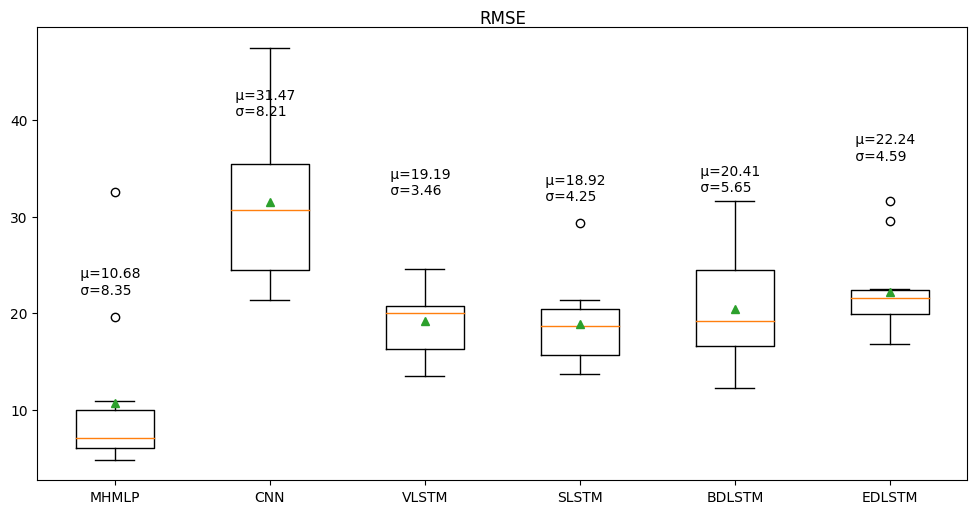

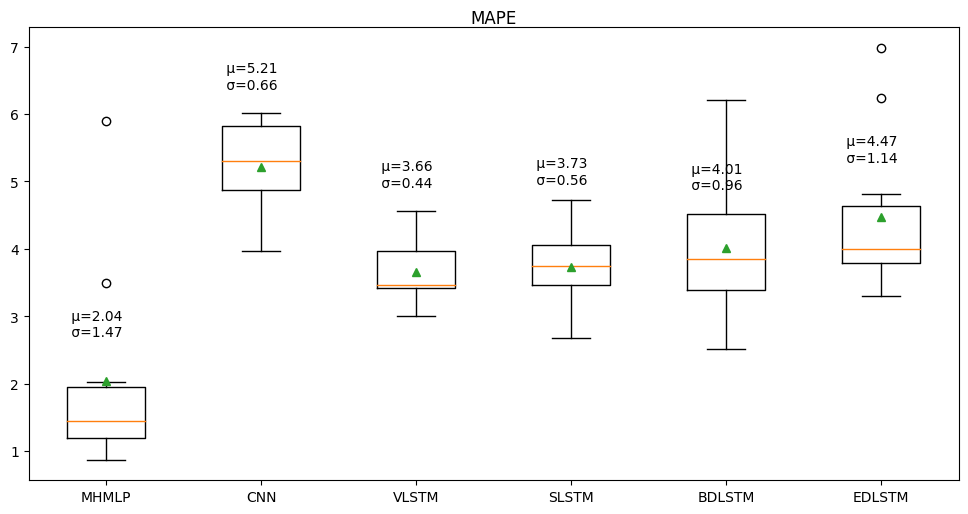

In [138]:
name=['MHMLP','CNN','VLSTM','SLSTM','BDLSTM','EDLSTM'] 
rmse=[]
mape=[]
for i in range(6):
    a=[Scores_rev[name[i]][k][0] for k in range(10)]
    b=[Scores_rev[name[i]][k][1] for k in range(10)]
    rmse.append(a)  
    mape.append(b)
plt.figure(figsize=(12,6), dpi=100)
fig1, ax1 = plt.subplots(figsize=(12,6), dpi=100)
plt.title('RMSE', pad=-40)
bp1 = plt.boxplot(rmse, labels=name, showmeans=True)
m1 = np.mean(rmse,1)
st1 = np.std(rmse,1)

for i, line in enumerate(bp1['boxes']):
    x, y = line.get_xydata()[0]
    text = ' μ={:.2f}\n σ={:.2f}'.format(m1[i], st1[i])
    ax1.annotate(text, xy=(x, y+16))

    
fig2, ax2 = plt.subplots(figsize=(12,6), dpi=100)
plt.title('MAPE', pad=-40)
bp2 = plt.boxplot(mape, labels=name, showmeans=True)
m2 = np.mean(mape,1)
st2 = np.std(mape,1)

for i, line in enumerate(bp2['boxes']):
    x, y = line.get_xydata()[0]
    text = ' μ={:.2f}\n σ={:.2f}'.format(m2[i], st2[i])
    ax2.annotate(text, xy=(x, y+1.5))
    
plt.show()




<Figure size 1200x600 with 0 Axes>

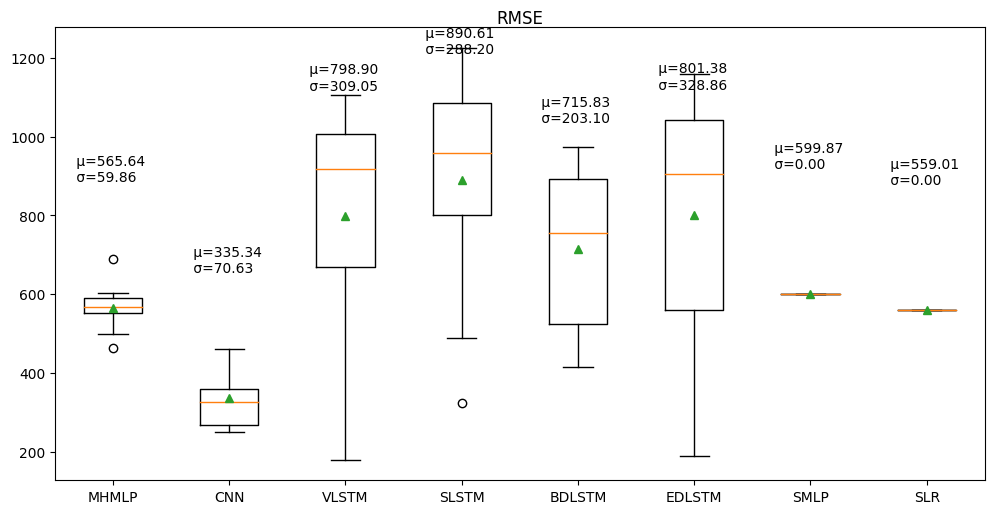

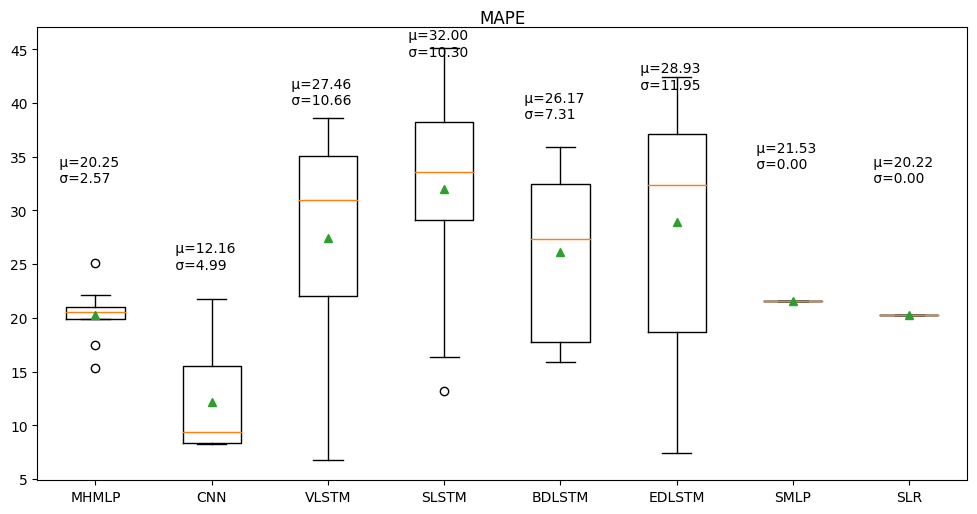

In [176]:
name=['MHMLP','CNN','VLSTM','SLSTM','BDLSTM','EDLSTM','SMLP', 'SLR'] 
rmse=[]
mape=[]
for i in range(6):
    rmse.append(rmse1[0,0,i*10:(i+1)*10-1])  
    mape.append(mape1[0,0,i*10:(i+1)*10-1])
rmse.append(array([rmse_smlp]))
rmse.append(array([rmse_slr]))
mape.append(array([mape_smlp]))
mape.append(array([mape_slr]))

plt.figure(figsize=(12,6), dpi=100)
fig1, ax1 = plt.subplots(figsize=(12,6), dpi=100)
plt.title('RMSE', pad=-40)
bp1 = plt.boxplot(rmse, labels=name, showmeans=True)
m1 = [rmse[i].mean() for i in range(8)]
st1 = [rmse[i].std() for i in range(8)]

for i, line in enumerate(bp1['means']):
    x, y = line.get_xydata()[0]
    text = ' μ={:.2f}\n σ={:.2f}'.format(m1[i], st1[i])
    ax1.annotate(text, xy=(x-0.35, y+320))

    
fig2, ax2 = plt.subplots(figsize=(12,6), dpi=100)
plt.title('MAPE', pad=-40)
bp2 = plt.boxplot(mape, labels=name, showmeans=True)
m2 = [mape[i].mean() for i in range(8)]
st2 = [mape[i].std() for i in range(8)]

for i, line in enumerate(bp2['means']):
    x, y = line.get_xydata()[0]
    text = ' μ={:.2f}\n σ={:.2f}'.format(m2[i], st2[i])
    ax2.annotate(text, xy=(x-0.35, y+12.4))
    
plt.show()

In [208]:
mape1

array([[[25.09055309, 15.32411398, 20.99435365, 22.08786325,
         19.85397717, 20.53709968, 20.6643224 , 17.51308089,
         20.17693105, 21.39157278, 21.77833937,  9.91808142,
          8.31124536,  8.79141545,  9.40241016,  8.24677307,
         15.498207  ,  8.22232878, 19.29895714, 10.06600257,
          6.79659215, 12.44140354, 22.07969509, 29.50583414,
         30.97882764, 35.08965133, 34.58484665, 38.57345007,
         37.0453455 , 38.88238536, 13.20471378, 16.34810096,
         29.1442388 , 32.81518469, 33.58657468, 37.31810591,
         38.21286042, 42.24774399, 45.14078202, 45.47770918,
         17.78335292, 15.92583188, 17.33585217, 23.55949628,
         27.36270534, 31.66662473, 32.50842572, 33.48125658,
         35.91388974, 40.72917084,  7.43917918, 14.45946268,
         18.7007906 , 28.41000423, 32.35153829, 37.00811563,
         37.16348327, 42.4506769 , 42.36904776, 44.97810083]]])

In [209]:
rmse1

array([[[ 688.37400616,  462.7176268 ,  590.71035466,  602.51838251,
          551.57623264,  566.43916656,  570.70699394,  499.91466996,
          557.83093794,  583.24627444,  462.15696186,  251.34848505,
          267.39555852,  360.32009975,  256.18554875,  326.42740306,
          350.98433082,  311.17586339,  432.02811978,  272.56272432,
          179.93128334,  370.62823737,  668.77904007,  854.79353681,
          919.00497875, 1004.03662285, 1007.60343032, 1105.70813238,
         1079.59959358, 1120.51190113,  325.04093596,  488.2351092 ,
          802.24091773,  911.29047482,  958.1694355 , 1052.23969676,
         1084.64595116, 1168.01020408, 1225.59846357, 1226.35346912,
          416.47843945,  436.83117006,  525.52344014,  655.23159916,
          755.09656519,  866.46630329,  893.33808359,  919.31728098,
          974.21433286, 1094.25118   ,  188.10711884,  387.19090337,
          560.8772545 ,  797.77210357,  906.14018809, 1016.46857044,
         1042.67561591, 1152.97860

In [393]:
np.save('stackX0.npy', stackX0, allow_pickle=True)
np.save('stackX1.npy', stackX1, allow_pickle=True)
np.save('rmse0.npy', rmse0, allow_pickle=True)
np.save('rmse1.npy', rmse1, allow_pickle=True)
np.save('mape0.npy', mape0, allow_pickle=True)
np.save('mape1.npy', mape1, allow_pickle=True)

In [187]:
stackX1[:,40].shape

(154,)

<Figure size 1800x900 with 0 Axes>

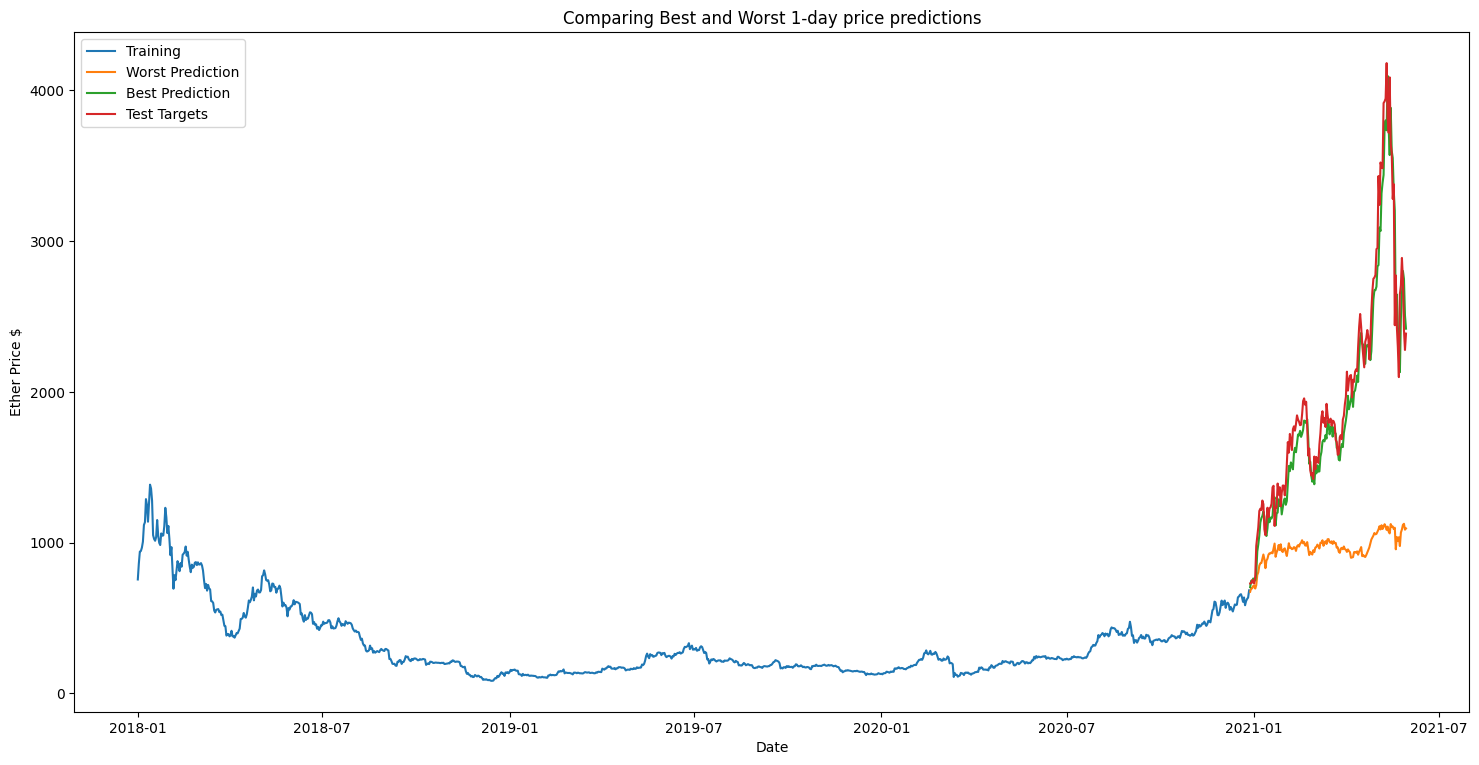

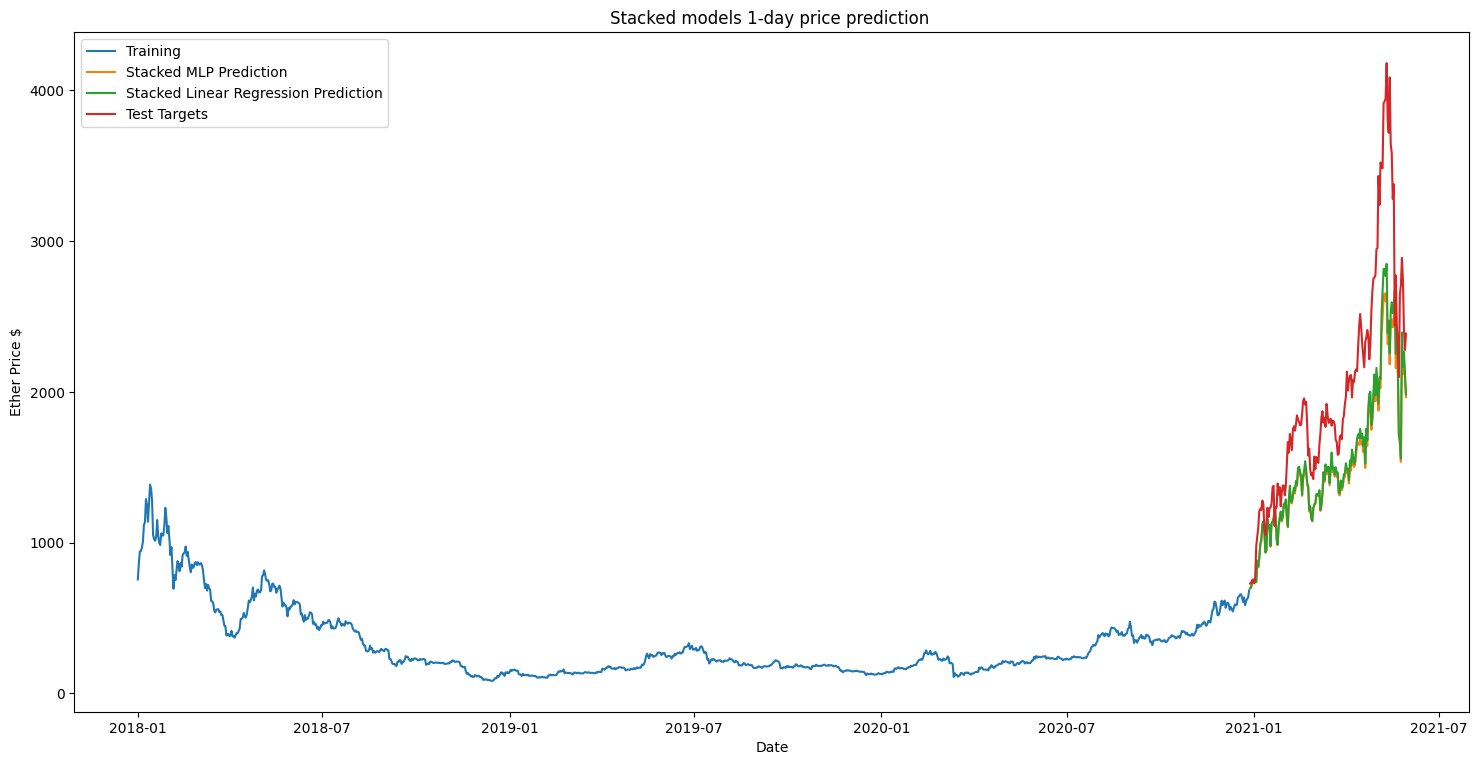

In [219]:
predictions_worst = stackX1[:,39]
predictions_best = stackX1[:,20]
predict_smlp = predict_stacked_mlp(stacked_mlp, stackX1)
predict_slr = predict_stacked_lr(stacked_lr, stackX1 )

# evaluate ensemble models

y_hatrev_smlp = np.exp(scaler.inverse_transform(np.concatenate((predict_smlp.reshape(predict_smlp.shape[0]*predict_smlp.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(predict_smlp),42))), axis=1))[:,0])-1

y_hatrev_slr = np.exp(scaler.inverse_transform(np.concatenate((predict_slr.reshape(predict_slr.shape[0]*predict_slr.shape[1])
                                                              .reshape(-1, 1),np.zeros((len(predict_slr),42))), axis=1))[:,0])-1

# Plot rescaled outputs
y_trainrev=np.exp(scaler.inverse_transform(train.reshape(train.shape[0]*train.shape[1],train.shape[2] ))[:,0])-1
y_testrev=np.exp(scaler.inverse_transform(np.concatenate((test_y.reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])-1
y_predrev_Worst=np.exp(scaler.inverse_transform(np.concatenate((predictions_worst.reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])-1
y_predrev_best=np.exp(scaler.inverse_transform(np.concatenate((predictions_best.reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])-1

plt.figure(figsize=(18,9), dpi=100)
fig1, ax1 = plt.subplots(figsize=(18,9), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev_Worst, label='Worst Prediction')
plt.plot(test_index, y_predrev_best, label='Best Prediction')

plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Comparing Best and Worst 1-day price predictions', xlabel='Date', ylabel='Ether Price $')
plt.legend()

fig1, ax1 = plt.subplots(figsize=(18,9), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_hatrev_smlp, label='Stacked MLP Prediction')
plt.plot(test_index, y_hatrev_slr, label='Stacked Linear Regression Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Stacked models 1-day price prediction ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()

In [197]:
np.concatenate((predictions.reshape(-1, 1), np.zeros((154,42))), axis=1)

array([[0.52737641, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.53951889, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.53207856, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.8696903 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.85377854, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.8470847 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [215]:
len(y_hatrev_smlp)

1078

In [202]:
y_testrev.shape

(168,)